In [1]:
''' Compiling all of the initial code from the project_start '''

!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt

events = Events("CheatedRecoFile_10.root")

view_u = View(events, "u")
view_v = View(events, "v")
view_w = View(events, "w")

view_w.z[1]

import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

import os

def save_plot(fig, directory, filename):
    if not os.path.exists(directory):
        os.mkdir(directory)
    fig.savefig(f'{directory}/{filename}.png', bbox_inches='tight', dpi=200, facecolor='w')
    fig.savefig(f'{directory}/{filename}.jpg', bbox_inches='tight', dpi=200)
    fig.savefig(f'{directory}/{filename}.svg', bbox_inches='tight', dpi=200)

  Using cached uproot-5.5.1-py3-none-any.whl.metadata (33 kB)
Using cached uproot-5.5.1-py3-none-any.whl (362 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.1/865.1 kB 12.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.7/637.7 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.6 MB/s eta 0:00:00:00:01


# The aims:
- To create a function that plots a single trail of a particle, be that track or shower
- Ise that plot to fit a straight line to the trail
- Include that straight line in the plot, just to show where the code thinks the best fit is
- Calculate the RMS value and print it
- Create a histogram that helps us decide if the trail is a track or shower

In [2]:
# used GPT to get me a function that splits and prints an array into parts with the same number, example at the bottom...

def split_and_print_array(arr):
    # Ensure the input is a NumPy array
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array.")

    # Identify changes in the array
    change_indices = np.where(np.diff(arr) != 0)[0] + 1
    
    # Split the array at change indices
    split_parts = np.split(arr, change_indices)
    
    # Print the resulting parts
    for i, part in enumerate(split_parts):
        print(f"Part {i + 1}: {part}")

# example

ex_array = np.array([1, 4, 4, 6, 6, 6, 6, 3, 3, 5, 8, 8, 8, 8, 19, 19])
split_and_print_array(ex_array)

Part 1: [1]
Part 2: [4 4]
Part 3: [6 6 6 6]
Part 4: [3 3]
Part 5: [5]
Part 6: [8 8 8 8]
Part 7: [19 19]


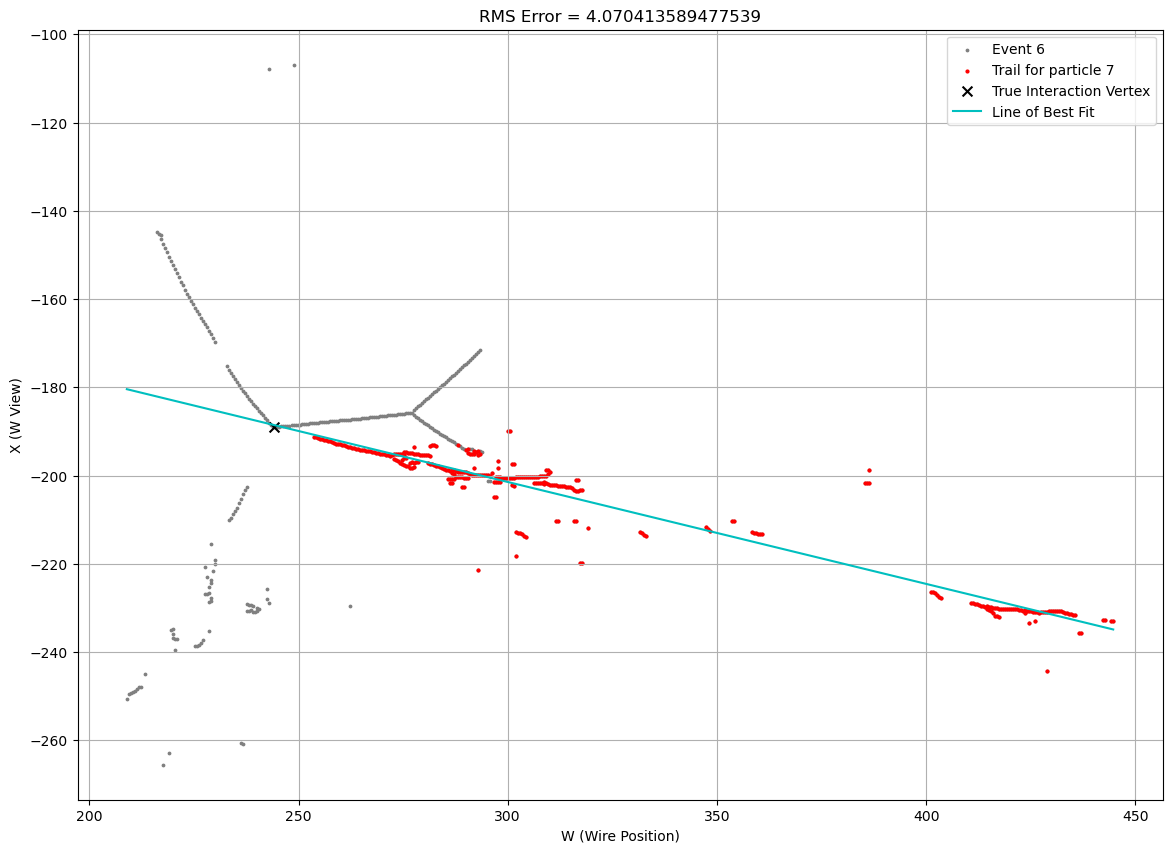

In [10]:
''' Fitting an RMS value to a single particle trail with a line of best fit '''

def single_trail_rms_plot(event_index, particle_no):

    rmse = 0 # declare as global at the start
    
    # Dealing with all the numbers associated with the "particle_no" parameter
    n_c = np.array(events.filter_by_event(events.reco_particle_index, event_index)) # critical number, the number of particles in the event
    if particle_no > n_c.size:
        return print(f'Invalid particle number, there are less than {n_c.size} particles in event {event_index}') # Raising a value error if there aren't enough particles in the event
    elif particle_no <= 0:
        return print('Please present a non-zero positive integer')

    
    
    # Filter the hits for the specific event
    w_hits = events.filter_by_event(events.reco_hits_w, event_index)
    x_hits = events.filter_by_event(events.reco_hits_x_w, event_index)
    
    # Flatten the arrays in case they are nested or contain multiple hits
    w_hits = np.concatenate(w_hits)  # Flatten to 1D array
    x_hits = np.concatenate(x_hits)  # Flatten to 1D array
    
    # Filtering the x and W values to highlight on the plot
    try:
        w_hits_highlight = events.filter_by_event(events.reco_hits_w, event_index)[particle_no - 1]
        x_hits_highlight = events.filter_by_event(events.reco_hits_x_w, event_index)[particle_no - 1]
    except IndexError as e:
        return print(f"Error accessing particle number {particle_no - 1}: {e}")

    # debugging
    #print(f'w_hits_highlight: {w_hits_highlight}')
    #print(f'x_hits_highlight: {x_hits_highlight}')
    
    # ensure highlighted hits aren't empty
    if w_hits_highlight.size == 0 or x_hits_highlight.size == 0:
        return print("Highlighted hits are empty")


    # Plotting for W view
    plt.figure(figsize=(14, 10))
    plt.scatter(w_hits, x_hits, marker='o', s=3, c='grey', label=f'Event {event_index}') # Event display or just x,W hits
    plt.scatter(w_hits_highlight, x_hits_highlight, s=4, c='r', label=f'Trail for particle {particle_no}') # Plot the points we are analysing

    # Plotting the vertex for more context
    true_vertex_w = events.filter_by_event(events.reco_particle_vtx_w, event_index)[0]
    true_vertex_x = events.filter_by_event(events.reco_particle_vtx_x, event_index)[0]
    plt.scatter(true_vertex_w, true_vertex_x, c='k', marker='x', s=50, label="True Interaction Vertex")


    
    # If there is a single hit from the particle, we CANNOT plot it, so it needs to be made clear as we plot the best fit...
    if w_hits_highlight.size == 1:
        rmse = "undefined for a single hit"
        print('Cannot plot line of best fit for a single hit')
    else:
        # Calculate the coefficients for the line of best fit (slope and intercept)
        slope, intercept = np.polyfit(w_hits_highlight, x_hits_highlight, 1)

        w_best_fit = np.linspace(w_hits.min(),w_hits.max(),200) # take a set of w values across the whole event view
        # Generate points for the line of best fit - visual aid. these points SHOULDN'T be used for any calculations
        x_best_fit = slope * w_best_fit + intercept

        plt.plot(w_best_fit, x_best_fit, color='c', label='Line of Best Fit') # Best fit line
    
        # Create numpy arrays for the actual and predicted values
        actual = x_hits_highlight
        predicted = slope * w_hits_highlight + intercept

        # Calculate the mean squared error (MSE) by taking the mean of the squared differences
        meanSquaredError = ((predicted - actual) ** 2).mean()
    
        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(meanSquaredError)
    
    # Set axis limits based on the data only, don't want anomalous best fit lines squashing the data
    w_limit_dummy = np.append(w_hits, true_vertex_w) # making sure to include the interaction vertex within the data for plot purposes
    x_limit_dummy = np.append(x_hits, true_vertex_x)
    padding_w = 0.05 * (np.max(w_limit_dummy) - np.min(w_limit_dummy)) # padding of 5% over the x and W ranges
    padding_x = 0.05 * (np.max(x_limit_dummy) - np.min(x_limit_dummy))
    plt.xlim(min(w_limit_dummy) - padding_w, max(w_limit_dummy) + padding_w) # using padding to get the x/W limits
    plt.ylim(min(x_limit_dummy) - padding_x, max(x_limit_dummy) + padding_x)


    # Plots
    plt.ylabel('X (W View)')
    plt.xlabel('W (Wire Position)')
    plt.title(f'RMS Error = {rmse}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting some example trails for tweaking purposes
#single_trail_rms_plot(4,1)
single_trail_rms_plot(6,7)
#single_trail_rms_plot(0,1)
#single_trail_rms_plot(52,3)
#single_trail_rms_plot(2,5) # the plot looks so squashed, with a quick look at the y axis, we can tell that its because of the line of best fit and it is restricted to all w values, 
                        # so a very tall corellation will squash the plot. May need to fix this. - Have done with the embedded padding.

# Now to plot the RMS values on a histogram.

Wanted to have a histogram of "fraction of particles" over "RMS" in the meeting.

To make it easier to get values, I will define a new function just called "rms" to get the rms values without plotting to clog the page up.

In [4]:
''' Solely the RMS '''

# For storage purposes
rms_array = np.empty((0,1)) # Empty 2d array
rmse = "Undefined"

def rms(event_index, particle_no):
    global rms_array  # Declare rms_array as global to modify it within the function
    global rmse
    
    # Dealing with all the numbers associated with the "particle_no" parameter
    n_c = np.array(events.filter_by_event(events.reco_particle_index, event_index)) # critical number, the number of particles in the event
    if particle_no > n_c.size:
        return print(f'Invalid particle number, there are less than {n_c.size} particles in event {event_index}') # Raising a value error if there aren't enough particles in the event
    elif particle_no <= 0:
        return print('Please present a non-zero positive integer')

    
    
    # Filter the hits for the specific event
    w_hits = events.filter_by_event(events.reco_hits_w, event_index)
    x_hits = events.filter_by_event(events.reco_hits_x_w, event_index)
    
    # Flatten the arrays in case they are nested or contain multiple hits
    w_hits = np.concatenate(w_hits)  # Flatten to 1D array
    x_hits = np.concatenate(x_hits)  # Flatten to 1D array
    
    # Filtering the x and W values to highlight on the plot
    w_hits_highlight = events.filter_by_event(events.reco_hits_w, event_index)[particle_no-1]
    x_hits_highlight = events.filter_by_event(events.reco_hits_x_w, event_index)[particle_no-1]
    
    if w_hits_highlight.size == 0 or x_hits_highlight.size == 0:
        return print('Particle has no hits')

    

    # If there is a single hit from the particle, we CANNOT plot it, so it needs to be made clear as we plot the best fit...
    if w_hits_highlight.size == 1:
        print('No line of best fit for a single hit')
    else:
        # Calculate the coefficients for the line of best fit (slope and intercept)
        slope, intercept = np.polyfit(w_hits_highlight, x_hits_highlight, 1)

        w_best_fit = np.linspace(w_hits.min(),w_hits.max(),200) # take a set of w values across the whole event view
        # Generate points for the line of best fit
        x_best_fit = slope * w_best_fit + intercept
    
        # Create numpy arrays for the actual and predicted values
        actual = x_hits_highlight
        predicted = slope * w_hits_highlight + intercept

        # Calculate the mean squared error (MSE) by taking the mean of the squared differences
        meanSquaredError = ((predicted - actual) ** 2).mean()
    
        # Calculate the RMSE by taking the square root of the MSE
        rmse = np.sqrt(meanSquaredError)
        rms_array = np.append(rms_array, rmse)
        print('Success')

for i in range(10):
    for j in range(10):
        rms(i,j)

print(rms_array)

Please present a non-zero positive integer
Particle has no hits
No line of best fit for a single hit
No line of best fit for a single hit
No line of best fit for a single hit
Success
No line of best fit for a single hit
Success
Success
No line of best fit for a single hit
Please present a non-zero positive integer
Success
Success
Success
Particle has no hits
No line of best fit for a single hit
No line of best fit for a single hit
Success
Particle has no hits
No line of best fit for a single hit
Please present a non-zero positive integer
Success
Success
No line of best fit for a single hit
Success
Success
Success
No line of best fit for a single hit
Success
Success
Please present a non-zero positive integer
Success
Invalid particle number, there are less than 1 particles in event 3
Invalid particle number, there are less than 1 particles in event 3
Invalid particle number, there are less than 1 particles in event 3
Invalid particle number, there are less than 1 particles in event 3
Inv